In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
#import altair as alt
import attila_utils

In [2]:
fpath = '../../resources/cell-based-assays/CO28151_outcome summary.xlsx'
res = pd.read_excel(fpath, 'CO28151', index_col=[0, 1, -1])
res['lower CL'] = res.loc[:, '95,00% CI of diff,'].apply(lambda s: np.float64(re.sub(',', '.', re.sub('^([+-]?[0-9,]+).*$', '\\1', s))))
res['upper CL'] = res.loc[:, '95,00% CI of diff,'].apply(lambda s: np.float64(re.sub(',', '.', re.sub('^.*to\s*([+-]?[0-9,]+)$', '\\1', s))))
res['reject H0'] = res.loc[:, 'Below threshold?'].apply(lambda s: True if re.match('Yes', s) else False)
#res['adjusted p-val'] = res.loc[:, 'Adjusted P Value'].apply(lambda s: np.float64(re.sub(',', '.', re.sub('^[<>]?([0-9,]+)$', '\\1', s))))
res['error'] = res.apply(lambda s: abs(s['upper CL'] - s['lower CL']) / 2, axis=1)
res['concentration'] = res.index.get_level_values('conc')
res['Summary'] = res.loc[:, 'Summary'].apply(lambda s: re.sub('ns', '', s))
res['Mean Diff,'] *= -1
upper_CL = res['lower CL'] * -1
lower_CL = res['upper CL'] * -1
res['upper CL'] = upper_CL
res['lower CL'] = lower_CL
res.to_csv('../../results/2023-04-20-cell-based-assays/CO28151-results.csv')
res

name  \
assay                       TI   conc                                   
Abeta celarance supernatant TI2  c1    Phenamil methanesulfonate salt   
                                 c2    Phenamil methanesulfonate salt   
                                 c3    Phenamil methanesulfonate salt   
                            TI3  c1    Benzamil hydrochloride hydrate   
                                 c2    Benzamil hydrochloride hydrate   
...                                                               ...   
LPS inflammation KC/GRO     TI13 c2                       Liraglutide   
                                 c3                       Liraglutide   
LPS inflammation MTT        TI13 c1                       Liraglutide   
                                 c2                       Liraglutide   
                                 c3                       Liraglutide   

                                      Bonferroni's multiple comparisons test  \
assay                       TI   conc                                          
Abeta celarance supernatant TI2  c1                                VC vs. c1   
                                 c2                                VC vs. c2   
                                 c3                                VC vs. c3   
                            TI3  c1                                VC vs. c1   
                                 c2                                VC vs. c2   
...                                                                      ...   
LPS inflammation KC/GRO     TI13 c2                               LPS vs. c2   
                                 c3                               LPS vs. c3   
LPS inflammation MTT        TI13 c1                               LPS vs. c1   
                                 c2                               LPS vs. c2   
                                 c3                               LPS vs. c3   

                                       Mean Diff, 95,00% CI of diff,  \
assay                       TI   conc                                  
Abeta celarance supernatant TI2  c1    -7889.0000      4674 to 11104   
                                 c2    -1328.0000      -1887 to 4543   
                                 c3    -4365.0000       1150 to 7580   
                            TI3  c1    -7398.0000       4830 to 9966   
                                 c2    -6674.0000       4105 to 9242   
...                                           ...                ...   
LPS inflammation KC/GRO     TI13 c2       -0.5517    -1,490 to 2,593   
                                 c3       -0.2617    -1,780 to 2,303   
LPS inflammation MTT        TI13 c1        3.0000    -14,20 to 8,199   
                                 c2        6.5000    -17,70 to 4,699   
                                 c3       -2.3330    -8,865 to 13,53   

                                      Below threshold? Summary  \
assay                       TI   conc                            
Abeta celarance supernatant TI2  c1                Yes     ***   
                                 c2                 No           
                                 c3                Yes      **   
                            TI3  c1                Yes     ***   
                                 c2                Yes     ***   
...                                                ...     ...   
LPS inflammation KC/GRO     TI13 c2                 No           
                                 c3                 No           
LPS inflammation MTT        TI13 c1                 No           
                                 c2                 No           
                                 c3                 No           

                                      Adjusted P Value   lower CL  upper CL  \
assay                       TI   conc                                         
Abeta celarance supernatant TI2  c1             <0,001 -11104.000 -4674.000   
                                 c2      

In [3]:
def assay_plot(assay='Abeta celarance supernatant'):
    df = res.xs(assay, level='assay', axis=0).copy()
    concentrations = list(df.concentration.unique())
    yticks = range(len(concentrations))
    colors = ['C' + str(i) for i in yticks]
    handles = [mpatches.Patch(color=c) for c in colors]
    gb = df.groupby('name')
    fig, ax = plt.subplots(len(gb), 1, sharex=False, figsize=(4, 2 * len(yticks)))
    fig.legend(handles, concentrations, loc='upper right')
    fig.suptitle(assay, horizontalalignment='right', verticalalignment='bottom', fontweight='bold')
    globalmax = df['upper CL'].max()
    globalmin = df['lower CL'].min()
    max_min = globalmax - globalmin
    margin = 0.02
    globalmax += margin * max_min
    globalmin -= margin * max_min
    for axi, datati in zip(ax, gb):
        name, dfti = datati
        #label = concentrations if axi == ax[-1] else None
        rectangles = axi.barh(data=dfti, y=yticks, width='Mean Diff,', color=colors, xerr='error')
        axi.bar_label(rectangles, labels=dfti.Summary, label_type='edge')
        #axi.bar_label(rectangles, labels=dfti.Summary, label_type='edge', verticalalignment='center')
        axi.set_ylabel(name, rotation='horizontal', verticalalignment='center', horizontalalignment='right')
        axi.set_yticks(yticks)
        axi.set_yticklabels([])
        axi.set_xlim([globalmin, globalmax])
        if axi == ax[-1]:
            sns.despine(left=False, bottom=False, top=True, right=True, ax=axi)
        else:
            sns.despine(left=False, bottom=True, top=True, right=True, ax=axi)
            axi.set_xticks([])
    return((fig, ax))

#fig, ax = assay_plot('Abeta celarance supernatant')

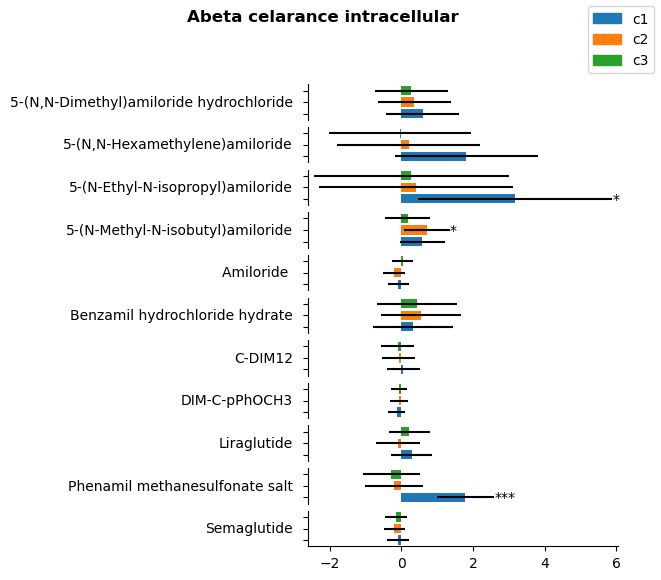

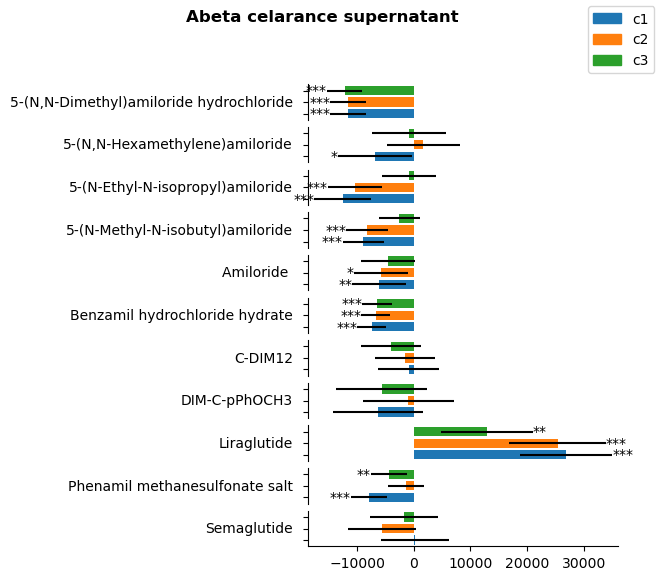

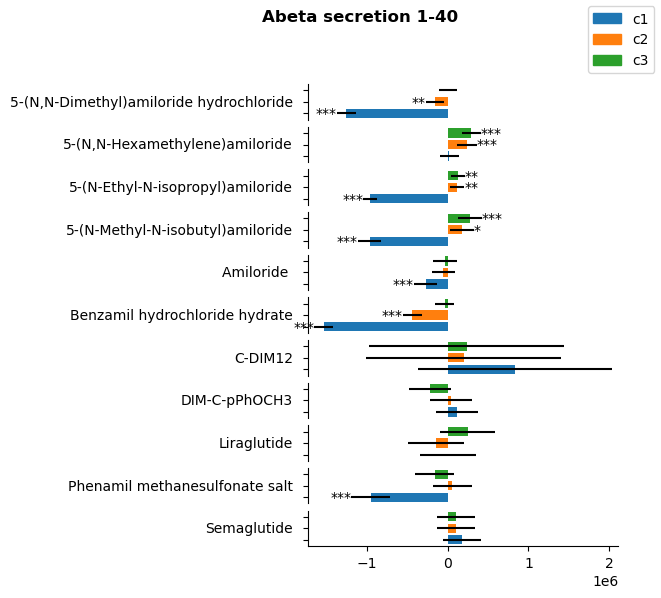

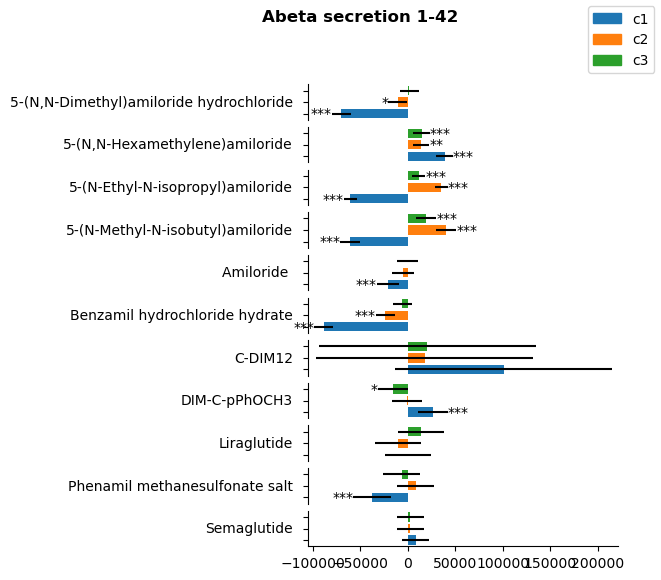

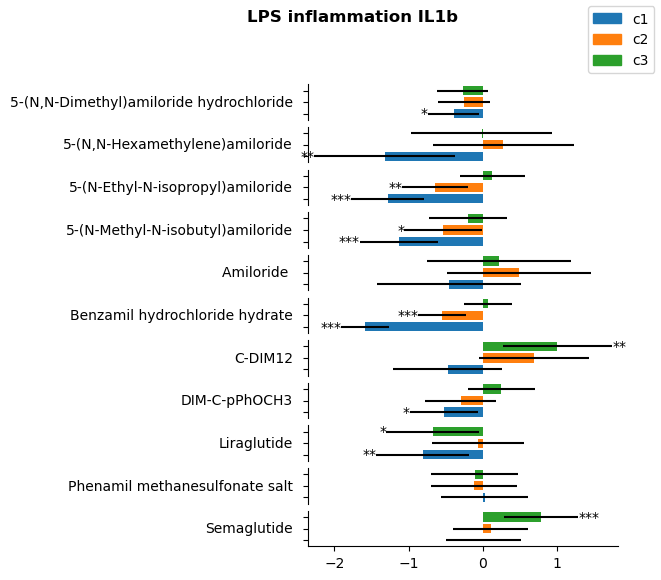

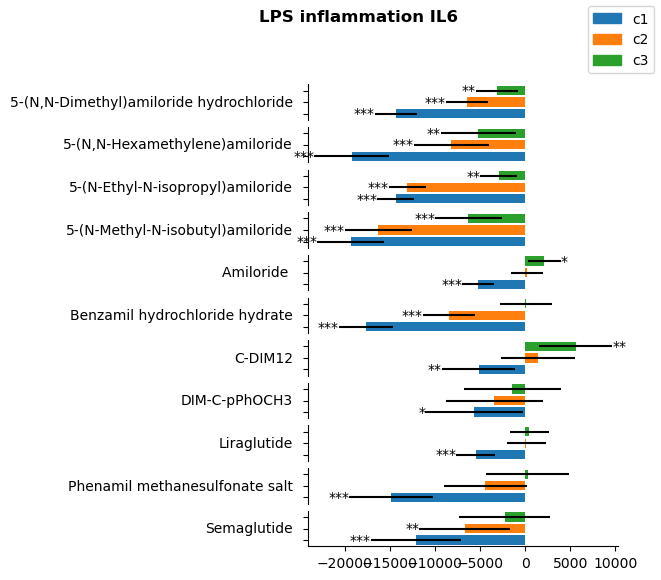

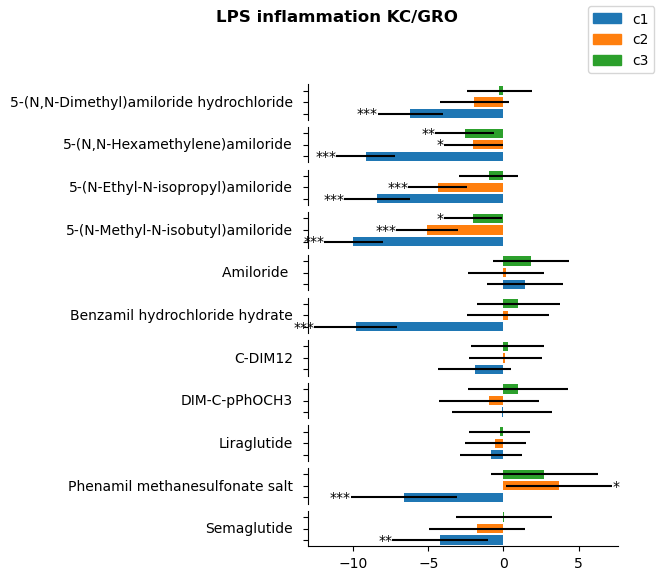

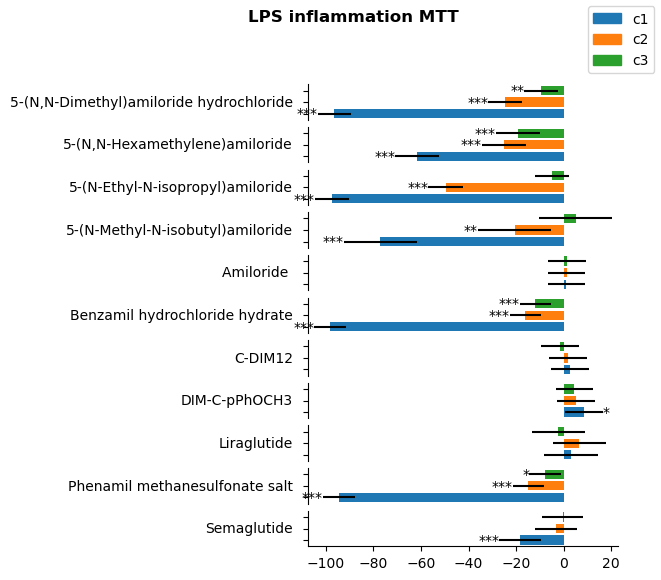

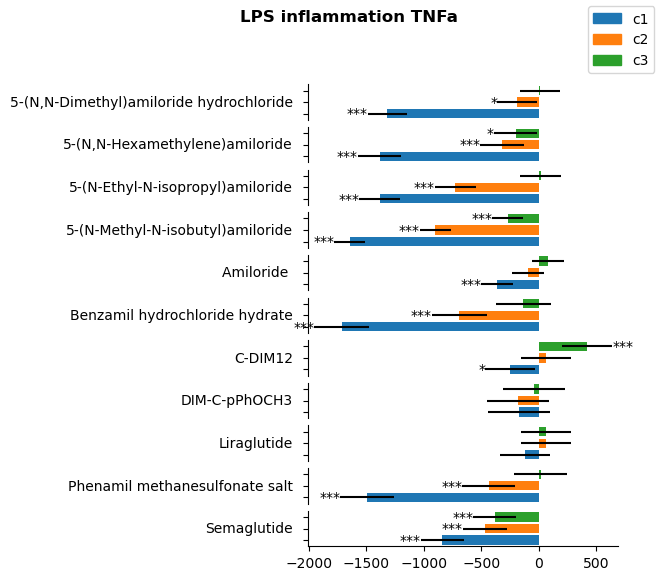

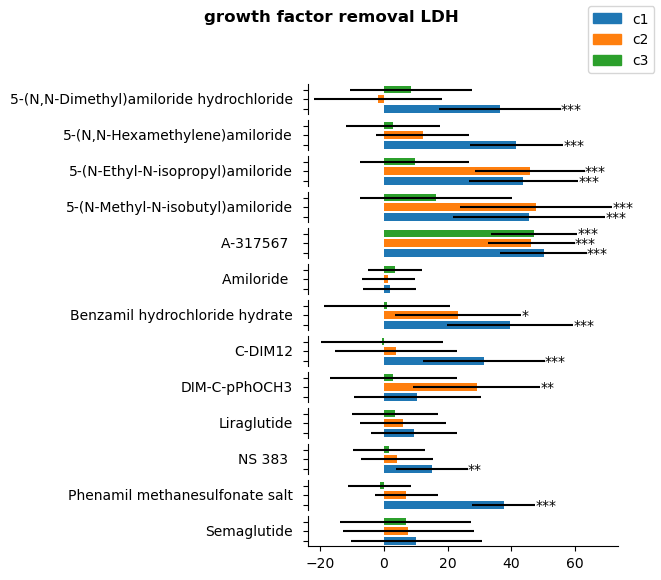

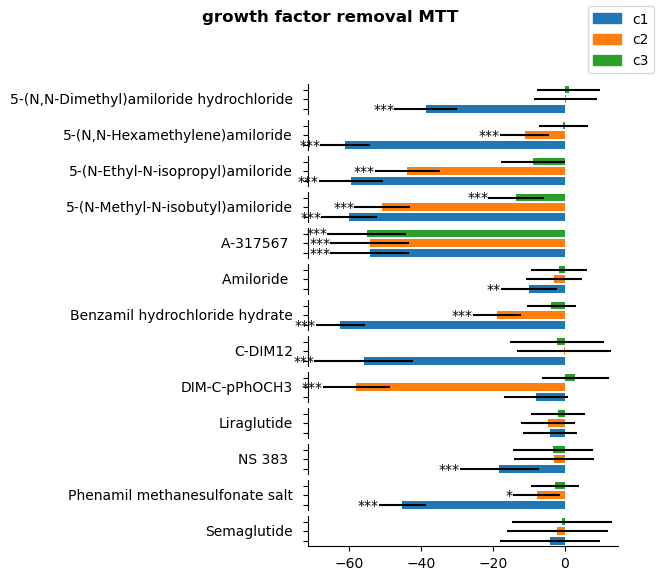

In [4]:
for assay, gb in res.groupby('assay'):
    fig, ax = assay_plot(assay)
    figname = re.sub('\W+', '-', assay)
    attila_utils.savefig(fig, figname)

In [5]:
%connect_info

{
  "shell_port": 53683,
  "iopub_port": 53684,
  "stdin_port": 53685,
  "control_port": 53687,
  "hb_port": 53686,
  "ip": "127.0.0.1",
  "key": "13d6ff9b-7925dbb186cb0ebb2427f85f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2023-04-20-cell-based-assays/2023-04-20-cell-based-assays.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-808bac1b-2899-465f-89f5-a9e7cbbb8c09.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
